Detecting Heart Disease Using Framingham Dataset



In [ ]:
!pip install gradio

In [ ]:
from google.colab import files
uploaded = files.upload()

Random Forest model trained successfully.


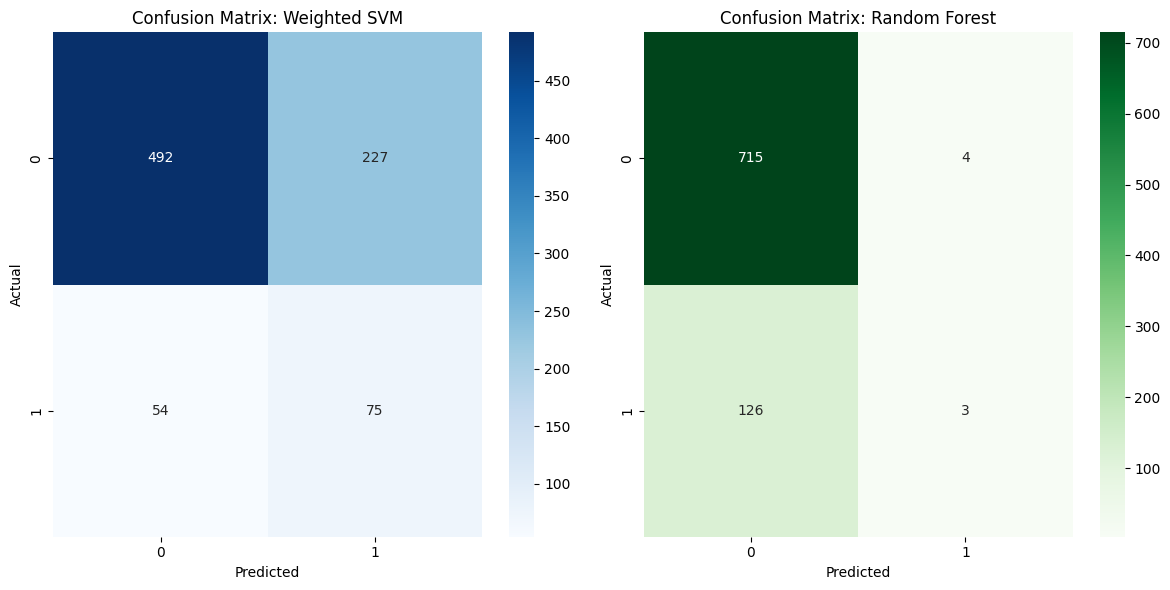

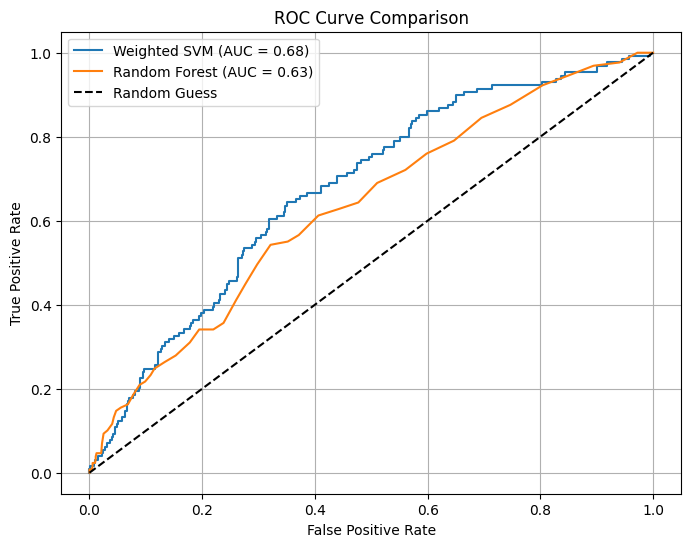

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://59a9fb6805eeafd43e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr

# Load dataset
data = pd.read_csv('framingham.csv')

# Preprocessing
# Handle missing values
imputer_mean = SimpleImputer(strategy='mean')
imputer_most_frequent = SimpleImputer(strategy='most_frequent')
columns_mean = ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']
columns_mode = ['education', 'BPMeds']
data[columns_mean] = imputer_mean.fit_transform(data[columns_mean])
data[columns_mode] = imputer_most_frequent.fit_transform(data[columns_mode])

# Scale numerical features
scaler = StandardScaler()
columns_to_scale = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Split data into features and target
X = data.drop(columns=['TenYearCHD'])
y = data['TenYearCHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Weighted SVM
svm_weighted = SVC(probability=True, class_weight='balanced', random_state=42)
svm_weighted.fit(X_train, y_train)

# Evaluate Weighted SVM
y_pred_svm = svm_weighted.predict(X_test)
y_pred_prob_svm = svm_weighted.predict_proba(X_test)[:, 1]
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Train Random Forest
try:
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    print("Random Forest model trained successfully.")
except Exception as e:
    print(f"Error during Random Forest training: {str(e)}")

# Evaluate Random Forest
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Visualizations
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix: Weighted SVM")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix: Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curves
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"Weighted SVM (AUC = {roc_auc_svm:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Gradio Integration
def predict_heart_disease(age, sex_male, cigs_per_day, tot_chol, sys_bp, glucose, model_type):
    try:
        # Prepare input data with all required features
        input_data = pd.DataFrame([{
            'age': age,
            'sex': sex_male,  # Binary: 0 (Female), 1 (Male)
            'education': 1,  # Default value
            'currentSmoker': 0,  # Default value for binary feature
            'cigsPerDay': cigs_per_day,
            'BPMeds': 0,  # Default value
            'prevalentStroke': 0,  # Default value
            'prevalentHyp': 0,  # Default value
            'diabetes': 0,  # Default value
            'totChol': tot_chol,
            'sysBP': sys_bp,
            'diaBP': 80,  # Default value
            'BMI': 25,  # Default value
            'heartRate': 70,  # Default value
            'glucose': glucose
        }])

        # Align input data with the training dataset's columns
        for col in X_train.columns:
            if col not in input_data:
                input_data[col] = 0  # Add missing columns with default value of 0

        # Ensure column order matches the training dataset
        input_data = input_data[X_train.columns]

        # Scale the input data
        input_data_scaled = scaler.transform(input_data)

        # Make prediction
        if model_type == "SVM":
            prediction = svm_weighted.predict(input_data_scaled)
            prob = svm_weighted.predict_proba(input_data_scaled)[:, 1]
        else:
            prediction = rf.predict(input_data_scaled)
            prob = rf.predict_proba(input_data_scaled)[:, 1]

        # Format output
        if prediction[0] == 0:
            return f"No Heart Disease (Low Risk), Probability: {prob[0]:.2f}"
        else:
            return f"Heart Disease (High Risk), Probability: {prob[0]:.2f}"
    except Exception as e:
        return f"Error in prediction: {str(e)}"




# Build Gradio Interface
interface = gr.Interface(
    fn=predict_heart_disease,
    inputs=[
        gr.Number(label="Age", value=50),
        gr.Radio(choices=[0, 1], label="Sex (0: Female, 1: Male)", value=1),
        gr.Number(label="Cigarettes per Day", value=0),
        gr.Number(label="Total Cholesterol (mg/dL)", value=200),
        gr.Number(label="Systolic Blood Pressure (mmHg)", value=120),
        gr.Number(label="Glucose Level (mg/dL)", value=90),
        gr.Radio(choices=["SVM", "Random Forest"], label="Model Type", value="SVM")
    ],
    outputs="text",
    live=True
)

# Launch the Gradio app
interface.launch()


In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import gradio as gr

In [9]:
# Load dataset
data = pd.read_csv('framingham.csv')  # dataset csv file 'framingham.csv'

In [8]:
# Step 1: Preprocessing
# Handle missing values
imputer_mean = SimpleImputer(strategy='mean')
imputer_most_frequent = SimpleImputer(strategy='most_frequent')

columns_mean = ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']
columns_mode = ['education', 'BPMeds']

data[columns_mean] = imputer_mean.fit_transform(data[columns_mean])
data[columns_mode] = imputer_most_frequent.fit_transform(data[columns_mode])

# Scale numerical features
scaler = StandardScaler()
columns_to_scale = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Split data into features and target
X = data.drop(columns=['TenYearCHD'])
y = data['TenYearCHD']

In [9]:
# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Step 3: Weighted SVM
svm_weighted = SVC(probability=True, class_weight='balanced', random_state=42)
svm_weighted.fit(X_train, y_train)

# Predictions and Evaluation for SVM
y_pred_svm = svm_weighted.predict(X_test)
y_pred_prob_svm = svm_weighted.predict_proba(X_test)[:, 1]

classification_rep_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm)

In [11]:
# Step 4: Random Forest with Reduced Optimization
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest Model and Parameters
rf_best = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_
print(f"Optimized Random Forest Parameters: {rf_best_params}")

# Predictions and Evaluation for Optimized Random Forest
y_pred_rf = rf_best.predict(X_test)
y_pred_prob_rf = rf_best.predict_proba(X_test)[:, 1]

classification_rep_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Optimized Random Forest Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [12]:
# Output Performance Comparison
print("\nWeighted SVM Classification Report:")
print(classification_rep_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)
print(f"ROC-AUC: {roc_auc_svm:.2f}\n")

print("Random Forest Classification Report:")
print(classification_rep_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"ROC-AUC: {roc_auc_rf:.2f}\n")


Weighted SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78       719
           1       0.25      0.58      0.35       129

    accuracy                           0.67       848
   macro avg       0.57      0.63      0.56       848
weighted avg       0.80      0.67      0.71       848

Confusion Matrix:
[[492 227]
 [ 54  75]]
ROC-AUC: 0.68

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       719
           1       0.43      0.02      0.04       129

    accuracy                           0.85       848
   macro avg       0.64      0.51      0.48       848
weighted avg       0.79      0.85      0.78       848

Confusion Matrix:
[[715   4]
 [126   3]]
ROC-AUC: 0.63



In [ ]:
# Gradio Integration
def predict_heart_disease(age, sex_male, cigs_per_day, tot_chol, sys_bp, glucose, model_type):
    try:
        # Feature names
        feature_names = ['age', 'sex', 'cigsPerDay', 'totChol', 'sysBP', 'education', 'BPMeds', 'glucose']

        # Prepare input data with all features
        input_data = pd.DataFrame([[
            age, sex_male, cigs_per_day, tot_chol, sys_bp, 0, 0, glucose  # Default values for missing features
        ]], columns=feature_names)

        # Scale input data
        input_data_scaled = scaler.transform(input_data)

        # Make prediction
        if model_type == "SVM":
            prediction = svm_weighted.predict(input_data_scaled)
            prob = svm_weighted.predict_proba(input_data_scaled)[:, 1]
        else:
            prediction = rf.predict(input_data_scaled)
            prob = rf.predict_proba(input_data_scaled)[:, 1]

        # Format output
        if prediction[0] == 0:
            return f"No Heart Disease (Low Risk), Probability: {prob[0]:.2f}"
        else:
            return f"Heart Disease (High Risk), Probability: {prob[0]:.2f}"
    except Exception as e:
        return f"Error in prediction: {str(e)}"






# Build Gradio Interface
interface = gr.Interface(
    fn=predict_heart_disease,
    inputs=[
        gr.Number(label="Age", value=50),
        gr.Radio(choices=[0, 1], label="Sex (0: Female, 1: Male)", value=1),
        gr.Number(label="Cigarettes per Day", value=0),
        gr.Number(label="Total Cholesterol (mg/dL)", value=200),
        gr.Number(label="Systolic Blood Pressure (mmHg)", value=120),
        gr.Number(label="Glucose Level (mg/dL)", value=90),
        gr.Radio(choices=["SVM", "Random Forest"], label="Model Type", value="SVM")
    ],
    outputs="text",
    live=True
)

# Launch the Gradio app
interface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d6734376a62c0ef201.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
